Code to get API (no authentication required) and save to JSON. For the assignment, we could:
1. Set up a scrip to call this every 10s or so or
2. Set up a flask server, so that when we call the flask server (perhaps with a country, state, region, etc.) it downloads the JSON from the api and loads it to the Kafka queue.

In [110]:
!curl https://opensky-network.org/api/states/all > openskystates.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1025k    0 1025k    0     0  25383      0 --:--:--  0:00:41 --:--:--  256k


Looking at the JSON file, it is fairly simple. It has a time, and then an array called `states`. The time is just the time in UTC, the `states` array contains one item for each plane being tracked.

In [111]:
!cat openskystates.json | jq '. |= keys'

[
  "states",
  "time"
]


In [112]:
!cat openskystates.json | jq '. | {time}'

{
  "time": 1626030850
}


This is the number being tracked:

In [113]:
!cat openskystates.json | jq '.states | length'

7905


This is what the first `states` array item looks like. There is a bunch of info from the plane (please see the table below for what each one means). We would have to parse this into a table with Spark and then land it into Hadoop. The two most important fields are the lattitude and longitude, although it might be cool to use some of the other variables. 

In [114]:
!cat openskystates.json | jq '.states[0]'

[
  "ab1644",
  "UAL1457 ",
  "United States",
  1626030849,
  1626030849,
  -77.8455,
  37.617,
  5509.26,
  false,
  195.25,
  24.27,
  -8.13,
  null,
  5829.3,
  "3252",
  false,
  0
]


The size of this dataset varies by API call, but if we refresh every 10 seconds, we should be well under a Gigabyte an hour, so that shouldn't be a problem for a lie demo.

In [115]:
# .59MB / 1000MB/ GB * 6 Updates/Minute * 60 Minutes/Hour 
print("Updates every 10 seconds: %.2f GB/Hour" % (.59 / 1000 * 6 * 60 * 1))

Updates every 10 seconds: 0.21 GB/Hour


Here are what each field in the `states` array means:

Opensky API Documentation: 
https://opensky-network.org/apidoc/rest.html

<!-- * Find API
* Write Python Script/Flask
* Push to Kafka
* Spark -> HDFS
* HDFS -> ShinyServer -->

| Index | Property        | Type    | Description                                                                                                                               |
|-------|-----------------|---------|-------------------------------------------------------------------------------------------------------------------------------------------|
| 0     | icao24          | string  | Unique ICAO 24-bit address of the transponder in hex string representation.                                                               |
| 1     | callsign        | string  | Callsign of the vehicle (8 chars). Can be null if no callsign has been received.                                                          |
| 2     | origin_country  | string  | Country name inferred from the ICAO 24-bit address.                                                                                       |
| 3     | time_position   | int     | Unix timestamp (seconds) for the last position update. Can be null if no position report was received by OpenSky within the past 15s.     |
| 4     | last_contact    | int     | Unix timestamp (seconds) for the last update in general. This field is updated for any new, valid message received from the transponder.  |
| 5     | longitude       | float   | WGS-84 longitude in decimal degrees. Can be null.                                                                                         |
| 6     | latitude        | float   | WGS-84 latitude in decimal degrees. Can be null.                                                                                          |
| 7     | baro_altitude   | float   | Barometric altitude in meters. Can be null.                                                                                               |
| 8     | on_ground       | boolean | Boolean value which indicates if the position was retrieved from a surface position report.                                               |
| 9     | velocity        | float   | Velocity over ground in m/s. Can be null.                                                                                                 |
| 10    | true_track      | float   | True track in decimal degrees clockwise from north (north=0°). Can be null.                                                               |
| 11    | vertical_rate   | float   | Vertical rate in m/s. A positive value indicates that the airplane is climbing, a negative value indicates that it descends. Can be null. |
| 12    | sensors         | int[]   | IDs of the receivers which contributed to this state vector. Is null if no filtering for sensor was used in the request.                  |
| 13    | geo_altitude    | float   | Geometric altitude in meters. Can be null.                                                                                                |
| 14    | squawk          | string  | The transponder code aka Squawk. Can be null.                                                                                             |
| 15    | spi             | boolean | Whether flight status indicates special purpose indicator.                                                                                |
| 16    | position_source | int     | Origin of this state’s position: 0 = ADS-B, 1 = ASTERIX, 2 = MLAT                                                                         |

After we have downloaded and munged the data, we can do a demonstration using GeoPandas to show a map. We can obviously do more complex things than this (i.e. we need to deduplicate the data by Flight Number) , and we will have to create a docker container with geopandas installed, but this is a demo of how we can use the data.

In [118]:
!pip install geopandas

In [143]:
import geopandas
import pandas as pd
import json 
import matplotlib.pyplot as plt
# Get world map from built-in dataset
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# Read downloaded JSON
planes = pd.read_json('/home/jupyter/openskyapi_test/openskystates.json')
# Extract lattitude, and longitude
# We would do this in Spark with the pipeline, not in Pandas
# But for demonstration purposes I did it in Pandas
planes['longitude'] = [x[5] for x in planes.states]
planes['lattitude'] = [x[6] for x in planes.states]
# Create a geographic data frame of the planes
gdf = geopandas.GeoDataFrame(
    planes, 
    geometry = geopandas.points_from_xy(planes.longitude, 
                                       planes.lattitude)
)

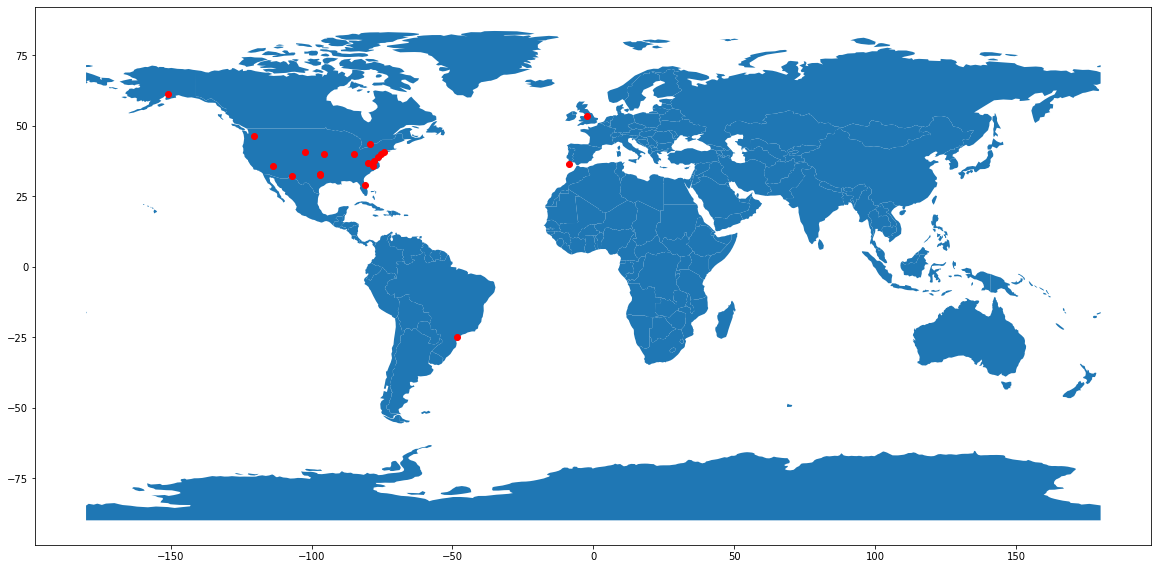

In [144]:
# Show world map
ax = world.plot(figsize = (20,50)) 
# Show first 20 flights
gdf.iloc[0:20].plot(ax = ax, color = 'red')
plt.show()